In [1]:
import zipfile
import os

zip_path = "flower.zip"  # Change this to your zip file name
extract_folder = "flowers_dataset"

# Step 1: Check & Extract
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("✅ Dataset extracted successfully!")
else:
    print("❌ ZIP file not found!")

✅ Dataset extracted successfully!


# Step 1: DataSet

In [3]:
import os
import shutil

# Outer folder (after first extraction)
outer_folder = "flowers_dataset"

# Check inside outer folder
inner_contents = os.listdir(outer_folder)
print("📂 Inner contents:", inner_contents)

# Step 1: Detect if there is a single sub-folder
if len(inner_contents) == 1 and os.path.isdir(os.path.join(outer_folder, inner_contents[0])):
    inner_folder_path = os.path.join(outer_folder, inner_contents[0])
    print(f"ℹ Found inner folder: {inner_folder_path}")

    # Step 2: Move all files/folders from inner to outer
    for item in os.listdir(inner_folder_path):
        src_path = os.path.join(inner_folder_path, item)
        dst_path = os.path.join(outer_folder, item)
        shutil.move(src_path, dst_path)

    # Step 3: Delete empty inner folder
    os.rmdir(inner_folder_path)
    print("✅ Inner folder flattened successfully!")

else:
    print("ℹ No single inner folder detected — skipping flatten.")

📂 Inner contents: ['daisy', 'dandelion', 'flowers', 'rose', 'sunflower', 'tulip']
ℹ No single inner folder detected — skipping flatten.


In [5]:
import os

# Dekho current working directory
print("Current directory:", os.getcwd())

# Dekho flowers_dataset ke andar kya hai
print("Inside flowers_dataset:", os.listdir("flowers_dataset"))


Current directory: C:\Users\asna\ML Internship DEN\task 3
Inside flowers_dataset: ['daisy', 'dandelion', 'flowers', 'rose', 'sunflower', 'tulip']


# Required Imports

In [9]:
import os
import zipfile
import splitfolders
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image


from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf


# Step 2: Model Implementation

# A. Data Preparation

# Organize dataset into folders (train/, val/, test/)

In [10]:
!pip install split-folders

In [14]:
import splitfolders

splitfolders.ratio(
    "flowers_dataset/flowers",  # yahan pe wo path jisme direct class folders hain
    output="flowers_split",
    seed=42,
    ratio=(0.7, 0.2, 0.1)
)

print("Dataset split successfully into train/ val/ test/")


Copying files: 4317 files [01:29, 48.49 files/s]

Dataset split successfully into train/ val/ test/


# Resize all images (e.g., 224×224)

In [ ]:
from PIL import Image
import os

# Function to resize all images in a folder
def resize_images_in_folder(folder_path, target_size=(224, 224)):
    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(subdir, file)
                try:
                    img = Image.open(img_path)
                    img = img.resize(target_size)
                    img.save(img_path)  # Overwrite original
                except Exception as e:
                    print(f"Error resizing {img_path}: {e}")

# Paths for train, val, and test folders
resize_images_in_folder("flowers_split/train")
resize_images_in_folder("flowers_split/val")
resize_images_in_folder("flowers_split/test")

print("All images resized to 224×224 successfully!")

# Normalize & Apply Data Augmentation

In [33]:
import os


output = r"C:\Users\asna\ML Internship DEN\task 3\flowers_split"

train_dir = os.path.join(output, 'train')
val_dir   = os.path.join(output, 'val')
test_dir  = os.path.join(output, 'test')

print(train_dir)
print(val_dir)
print(test_dir)


C:\Users\asna\ML Internship DEN\task 3\flowers_split\train
C:\Users\asna\ML Internship DEN\task 3\flowers_split\val
C:\Users\asna\ML Internship DEN\task 3\flowers_split\test


In [35]:
# Image size
img_size = (224, 224)
batch_size = 32

train_dir = os.path.join(output, 'train')
val_dir = os.path.join(output, 'val')
test_dir = os.path.join(output, 'test')

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data only rescaled
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3019 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Found 438 images belonging to 5 classes.


In [40]:
# Number of classes from training generator
num_classes = train_generator.num_classes
print("Number of classes:", num_classes)

Number of classes: 5


# B. Pre-trained CNN Model

# 1) MobileNetV2 Model

In [42]:
# Load MobileNetV2 base model without top layers, pretrained on imagenet
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

# Freeze the base model layers initially
for layer in mobilenet_base.layers:
    layer.trainable = False

# Add classification head
x = Flatten()(mobilenet_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=output)

# Compile model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV2 model built and compiled.")

MobileNetV2 model built and compiled.


In [44]:
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=1,  
    validation_data=val_generator
)

C:\Users\asna\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6830 - loss: 0.9904 - val_accuracy: 0.8209 - val_loss: 0.4850


# 2) NASNetMobile Model

In [45]:
# Load NASNetMobile base model without top layers, pretrained on imagenet
nasnet_base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

# Freeze base layers initially
for layer in nasnet_base.layers:
    layer.trainable = False

# Add classification head
x = Flatten()(nasnet_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

nasnet_model = Model(inputs=nasnet_base.input, outputs=output)

# Compile model
nasnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("NASNetMobile model built and compiled.")

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 51s 3us/step
NASNetMobile model built and compiled.


In [48]:
nasnet_history = nasnet_model.fit(
    train_generator,
    epochs=1,
    validation_data=val_generator
)

95/95 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6323 - loss: 1.0737 - val_accuracy: 0.8023 - val_loss: 0.5086


# Save both Models

In [50]:
mobilenet_model.save("mobilenet_model.h5", include_optimizer=False)
nasnet_model.save("nasnet_model.h5", include_optimizer=False)
print("Models saved successfully!")

Models saved successfully!


# C. Evaluation

# Evaluating Accuracy & Loss for both models

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [60]:
# MobileNetV2 Evaluation
print("MobileNetV2 Evaluation:")
mobile_loss, mobile_acc = mobilenet_model.evaluate(test_generator)
print(f" MobileNetV2 Test Accuracy: {mobile_acc*100:.2f}%")
print(f" MobileNetV2 Test Loss: {mobile_loss:.4f}")

# NASNetMobile Evaluation 
print("NASNetMobile Evaluation:")
nasnet_loss, nasnet_acc = nasnet_model.evaluate(test_generator)
print(f" NASNetMobile Test Accuracy: {nasnet_acc*100:.2f}%")
print(f" NASNetMobile Test Loss: {nasnet_loss:.4f}")

MobileNetV2 Evaluation:
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8425 - loss: 0.4010
 MobileNetV2 Test Accuracy: 84.25%
 MobileNetV2 Test Loss: 0.4010
NASNetMobile Evaluation:
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7968 - loss: 0.4927
 NASNetMobile Test Accuracy: 79.68%
 NASNetMobile Test Loss: 0.4927


# Confusion Matrix for both models

14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


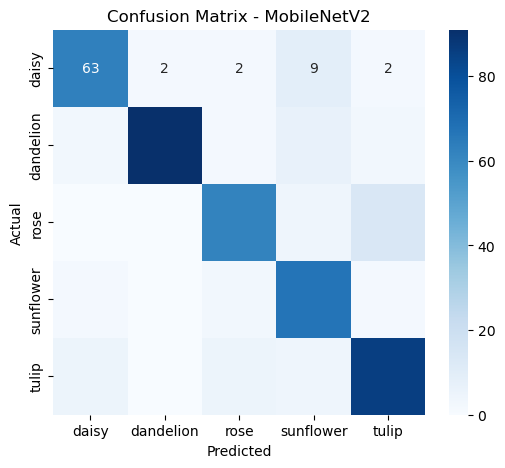


Classification Report - MobileNetV2:

              precision    recall  f1-score   support

       daisy       0.86      0.81      0.83        78
   dandelion       0.98      0.86      0.91       106
        rose       0.84      0.78      0.81        80
   sunflower       0.74      0.91      0.81        74
       tulip       0.80      0.86      0.83       100

    accuracy                           0.84       438
   macro avg       0.84      0.84      0.84       438
weighted avg       0.85      0.84      0.84       438

14/14 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step 


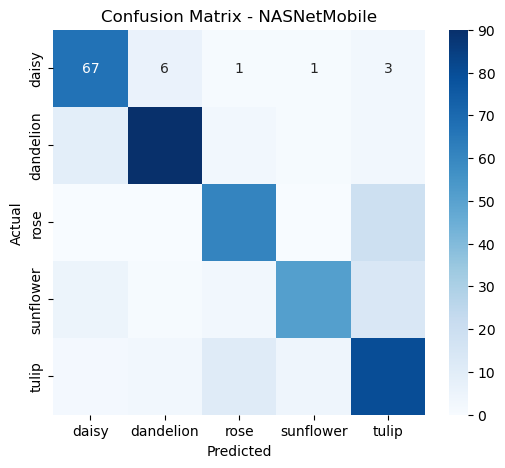


Classification Report - NASNetMobile:

              precision    recall  f1-score   support

       daisy       0.81      0.86      0.83        78
   dandelion       0.90      0.85      0.87       106
        rose       0.77      0.76      0.77        80
   sunflower       0.89      0.69      0.78        74
       tulip       0.67      0.80      0.73       100

    accuracy                           0.80       438
   macro avg       0.81      0.79      0.80       438
weighted avg       0.81      0.80      0.80       438



In [63]:
class_labels = list(test_generator.class_indices.keys())

def plot_confusion_matrix(model, generator, title):
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"\nClassification Report - {title}:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

plot_confusion_matrix(mobilenet_model, test_generator, "MobileNetV2")
plot_confusion_matrix(nasnet_model, test_generator, "NASNetMobile")

# Plot Training/Validation Accuracy & Loss

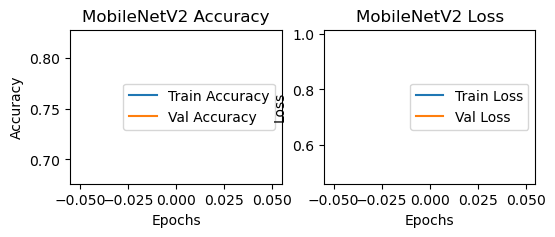

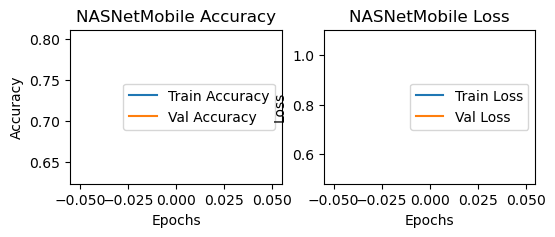

In [75]:
def plot_training(history, title):
    plt.figure(figsize=(6,2))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(mobilenet_history, "MobileNetV2")
plot_training(nasnet_history, "NASNetMobile")

#  Visualize Predictions with Probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


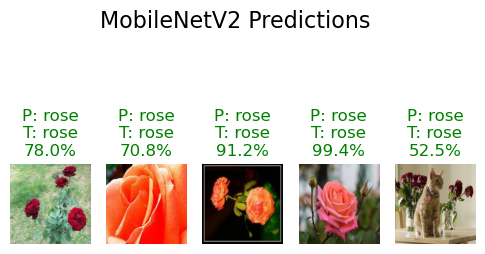

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


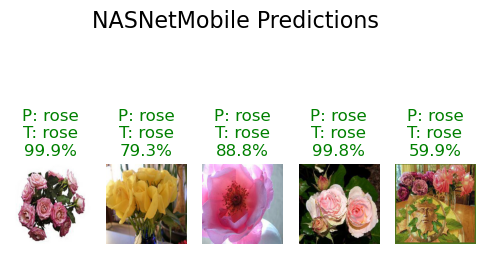

In [81]:
def visualize_predictions(model, generator, title, num_images=5):
    x, y = next(generator)  # batch
    preds = model.predict(x)
    y_true = np.argmax(y, axis=1)
    y_pred = np.argmax(preds, axis=1)

    plt.figure(figsize=(6,4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x[i])
        plt.axis('off')
        pred_label = class_labels[y_pred[i]]
        true_label = class_labels[y_true[i]]
        prob = np.max(preds[i]) * 100
        color = "green" if y_pred[i] == y_true[i] else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}\n{prob:.1f}%", color=color)
    plt.suptitle(f"{title} Predictions", fontsize=16)
    plt.show()

visualize_predictions(mobilenet_model, test_generator, "MobileNetV2")
visualize_predictions(nasnet_model, test_generator, "NASNetMobile")

In [71]:
# Save class labels
np.save("class_labels.npy", class_labels)